# EVI Analysis

* Fetch the GLC-FCS30D using Google Earth Engine
* Combine all the tiles in GLC into a global tile
* Given that each tile has multiple bands that represent multiple year, modify the data into an Image Collection
* Select all the cropland values only (10, 11, 12, and 20)
* Create mask for every cropland value and the overall cropland mask
* Fetch the EVI data and Bolivia boundaries
* Mask the EVI data using the cropland mask
* Visualize the EVI based on each cropland per year and clip to Bolivia only
* Export the map visualization as as static map
* Create a zonal stats for each region in Bolivia by aggregating into mean

## Import library and data

In [ ]:
from pathlib import Path
import json
import logging

import ee
import geemap
from gee_zonal import ZonalStats
import geemap.colormaps as cm
import geopandas as gpd
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)


PROJECT_ID = "ferrous-weaver-462011-d2"
ee.Initialize(project=PROJECT_ID)

PROJECT_ROOT = Path().cwd().parent
DATA_PATH = PROJECT_ROOT / "data"
BOUNDARIES_PATH = DATA_PATH / "boundaries"

ee.Initialize()

/Users/farhanreynaldo/Documents/world-bank/git-repo/bolivia-economic-monitor/.venv/lib/python3.11/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Functions

In [ ]:
def load_geojson_to_ee(
    geojson_path: str | Path,
) -> ee.FeatureCollection:
    """Load a GeoJSON file to Earth Engine.

    Args:
        geojson_path: The path to the GeoJSON file.

    Returns:
        An ee.FeatureCollection equivalent to the GeoJSON file.
    """
    if isinstance(geojson_path, str):
        geojson_path = Path(geojson_path)

    if not geojson_path.exists():
        raise FileNotFoundError(f"File not found: {geojson_path}")

    with open(geojson_path) as f:
        geojson = json.load(f)

    fc = ee.FeatureCollection(geojson)

    return fc


def fetch_boundaries(
    iso3_code: str,
    adm_level: int,
    release_type: str = "gbOpen",
    output_dir: str | Path = "../data/boundaries",
):
    """
    Fetch administrative boundaries from GeoBoundaries API.

    Args:
        iso3_code: ISO3 code of the country.
        adm_level: Administrative level (1, 2, etc.).
        release_type: Release type (e.g., "gbOpen", "gbCurrent").
        output_dir: Directory to save the downloaded GeoJSON file.

    Returns:
        An ee.FeatureCollection of the boundaries.
    """
    cache_dir = Path(output_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    cache_file = cache_dir / f"{iso3_code}_ADM{adm_level}_{release_type}.geojson"

    if cache_file.exists():
        logger.info(f"Loading boundaries from cache: {cache_file}")
        return load_geojson_to_ee(cache_file)

    url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3_code}/ADM{adm_level}"
    logger.info(f"Fetching boundaries from API: {url}")
    response = requests.get(url)
    response.raise_for_status()
    download_url = response.json()["gjDownloadURL"]
    logger.info(f"Downloading GeoJSON from: {download_url}")
    gdf = gpd.read_file(download_url)
    gdf.to_file(cache_file, driver="GeoJSON")
    logger.info(f"Boundaries saved to cache: {cache_file}")
    return load_geojson_to_ee(cache_file)


def bitwiseExtract(value: ee.Image, fromBit: int, toBit: int | None = None) -> ee.Image:
    """Extract bits from a binary image."""
    toBit = fromBit if toBit is None else toBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


def apply_modisQA_mask(image: ee.Image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    return image.updateMask(mask)


def load_evi_data(
    start_date: str | ee.Date,
    end_date: str | ee.Date,
    apply_crop_mask: bool = True,
) -> ee.ImageCollection:
    """
    Load EVI data from MODIS.

    Args:
        start_date: Start date.
        end_date: End date.
        apply_crop_mask: Whether to apply crop mask.

    Returns:
        EVI image collection.
    """

    terra = (
        ee.ImageCollection("MODIS/061/MOD13Q1")
        .select(["EVI", "SummaryQA", "DetailedQA"])
        .filterDate(start_date, end_date)
    )

    aqua = (
        ee.ImageCollection("MODIS/061/MYD13Q1")
        .select(["EVI", "SummaryQA", "DetailedQA"])
        .filterDate(start_date, end_date)
    )

    mod13q1_QC = terra.map(apply_modisQA_mask)
    myd13q1_QC = aqua.map(apply_modisQA_mask)
    mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
    mxd13q1 = mxd13q1_cleaned.sort("system:time_start")
    return mxd13q1

In [7]:
bolivia_geom = fetch_boundaries("BOL", 0, "gbOpen")
evi_data = load_evi_data("2014-01-01", "2022-12-31", apply_crop_mask=False)
center = [-16.2902, -63.5887]

bolivia_bbox = bolivia_geom.geometry().bounds()
bolivia_bbox = ee.Geometry.BBox(-69.6450073, -22.8982742, -57.453, -9.6689438)

## load and preprocessing the GLC

In [8]:
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")

class_values = [
    10,
    11,
    12,
    20,
    51,
    52,
    61,
    62,
    71,
    72,
    81,
    82,
    91,
    92,
    120,
    121,
    122,
    130,
    140,
    150,
    152,
    153,
    181,
    182,
    183,
    184,
    185,
    186,
    187,
    190,
    200,
    201,
    202,
    210,
    220,
    0,
]
class_names = [
    "Rainfed_cropland",
    "Herbaceous_cover_cropland",
    "Tree_or_shrub_cover_cropland",
    "Irrigated_cropland",
    "Open_evergreen_broadleaved_forest",
    "Closed_evergreen_broadleaved_forest",
    "Open_deciduous_broadleaved_forest",
    "Closed_deciduous_broadleaved_forest",
    "Open_evergreen_needle_leaved_forest",
    "Closed_evergreen_needle_leaved_forest",
    "Open_deciduous_needle_leaved_forest",
    "Closed_deciduous_needle_leaved_forest",
    "Open_mixed_leaf_forest",
    "Closed_mixed_leaf_forest",
    "Shrubland",
    "Evergreen_shrubland",
    "Deciduous_shrubland",
    "Grassland",
    "Lichens_and_mosses",
    "Sparse_vegetation",
    "Sparse_shrubland",
    "Sparse_herbaceous",
    "Swamp",
    "Marsh",
    "Flooded_flat",
    "Saline",
    "Mangrove",
    "Salt_marsh",
    "Tidal_flat",
    "Impervious_surfaces",
    "Bare_areas",
    "Consolidated_bare_areas",
    "Unconsolidated_bare_areas",
    "Water_body",
    "Permanent_ice_and_snow",
    "Filled_value",
]
class_colors = [
    "#ffff64",
    "#ffff64",
    "#ffff00",
    "#aaf0f0",
    "#4c7300",
    "#006400",
    "#a8c800",
    "#00a000",
    "#005000",
    "#003c00",
    "#286400",
    "#285000",
    "#a0b432",
    "#788200",
    "#966400",
    "#964b00",
    "#966400",
    "#ffb432",
    "#ffdcd2",
    "#ffebaf",
    "#ffd278",
    "#ffebaf",
    "#00a884",
    "#73ffdf",
    "#9ebb3b",
    "#828282",
    "#f57ab6",
    "#66cdab",
    "#444f89",
    "#c31400",
    "#fff5d7",
    "#dcdcdc",
    "#fff5d7",
    "#0046c8",
    "#ffffff",
    "#ffffff",
]

# Mosaic the data into a single image
annual_mosaic = annual.mosaic()

years_list = [str(y) for y in range(2000, 2023)]
annual_mosaic_renamed = annual_mosaic.rename(years_list)

# Convert the multiband image to an ImageCollection
images = []
for year_str in years_list:
    year_int = int(year_str)
    date = ee.Date.fromYMD(year_int, 1, 1)
    image = annual_mosaic_renamed.select([year_str]).set(
        {"system:time_start": date.millis(), "system:index": year_str, "year": year_int}
    )
    images.append(image)

mosaics_col = ee.ImageCollection.fromImages(images)

recode = False
if recode:
    new_class_values = list(range(1, len(class_values) + 1))

    def remap_classes(image):
        return image.remap(class_values, new_class_values).rename("classification")

    mosaics_col = mosaics_col.map(remap_classes)

In [9]:
## Parameters

YEAR = 2014
CROPLAND_CLASS = 11

cropland_values = [10, 11, 12, 20]  # Values for cropland classes

## Single cropland

In [37]:
image_sample = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()
crop_sample = image_sample.updateMask(image_sample.eq(CROPLAND_CLASS))

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    crop_sample,
    {},
    f"Land Cover {YEAR} - Cropland (Class {CROPLAND_CLASS})",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## Overall cropland

In [21]:
image_sample = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()

crop_mask = ee.Image(0)  # Start with an empty mask (all 0s)
for val in cropland_values:
    crop_mask = crop_mask.Or(image_sample.eq(val))

crop_sample = image_sample.updateMask(crop_mask)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    crop_sample,
    {},
    f"Land Cover {YEAR} - Cropland (Classes {', '.join(map(str, cropland_values))})",
    True,
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## EVI based on single cropland

In [55]:
vis_params = {"min": -2000, "max": 10000, "palette": cm.get_palette("Greens", 20)}

image_subset = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()
crop_mask = image_subset.eq(CROPLAND_CLASS)
evi_subset = evi_data.filterDate(
    ee.Date.fromYMD(YEAR, 1, 1), ee.Date.fromYMD(YEAR, 12, 31)
).mean()
evi_subset = evi_subset.updateMask(crop_mask)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    evi_subset,
    vis_params,
    f"Land Cover {YEAR}",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## EVI based on overall cropland

In [ ]:
vis_params = {"min": -2000, "max": 10000, "palette": cm.get_palette("Greens", 10)}

image_subset = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()

crop_mask = ee.Image(0)
for val in cropland_values:
    crop_mask = crop_mask.Or(image_subset.eq(val))

evi_subset = evi_data.filterDate(
    ee.Date.fromYMD(YEAR, 1, 1), ee.Date.fromYMD(YEAR, 12, 31)
).mean()

evi_subset = evi_subset.updateMask(crop_mask).clip(bolivia_geom)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    evi_subset,
    vis_params,
    f"Land Cover {YEAR}",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2014 EVI based on overall cropland

In [42]:
def create_overall_evi(year: int = 2014):
    image_subset = mosaics_col.filter(ee.Filter.eq("year", year)).mosaic()

    crop_mask = ee.Image(0)
    for val in cropland_values:
        crop_mask = crop_mask.Or(image_subset.eq(val))

    evi_subset = evi_data.filterDate(
        ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
    ).mean()

    evi_subset = evi_subset.updateMask(crop_mask).clip(bolivia_geom)

    m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
    m.addLayer(
        evi_subset,
        vis_params,
        f"Land Cover {year}",
    )
    return m

In [43]:
create_overall_evi(2014)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2015 EVI based on overall cropland

In [44]:
create_overall_evi(2015)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2016 EVI based on overall cropland

In [45]:
create_overall_evi(2016)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2017 EVI based on overall cropland

In [46]:
create_overall_evi(2017)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2018 EVI based on overall cropland

In [47]:
create_overall_evi(2018)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2019 EVI based on overall cropland

In [48]:
create_overall_evi(2019)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2020 EVI based on overall cropland

In [49]:
create_overall_evi(2020)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2021 EVI based on overall cropland

In [50]:
create_overall_evi(2021)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 2022 EVI based on overall cropland

In [51]:
create_overall_evi(2022)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## Overall zonal stats

In [ ]:
def calculate_evi_zonal_stats(
    region_path: str | Path,
    start_year: int = 2014,
    end_year: int = 2022,
    output_dir: str | Path = "../data/zonal_stats",
) -> ee.Image:
    """Calculate EVI zonal statistics for a range of years."""
    output_file = Path(output_dir) / f"evi_zonal_stats_{start_year}_{end_year}.csv"
    output_file.parent.mkdir(parents=True, exist_ok=True)
    if output_file.exists():
        logger.info(f"Zonal stats already calculated: {output_file}")
        return pd.read_csv(output_file)
    evi_images = []
    for year in range(start_year, end_year + 1):
        # Load crop mask for the specific year
        image_subset = mosaics_col.filter(ee.Filter.eq("year", year)).mosaic()
        crop_mask = ee.Image(0)
        for val in cropland_values:
            crop_mask = crop_mask.Or(image_subset.eq(val))

        # Load EVI data for the specific year
        evi_subset = evi_data.filterDate(
            ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
        ).mean()

        # Update the EVI image with the crop mask
        evi_subset = evi_subset.updateMask(crop_mask)
        evi_images.append(evi_subset)

    evi_images = ee.ImageCollection.fromImages(evi_images)

    gdf = gpd.read_file(region_path)

    # Loop over each feature in the geopandas and run the zonal stats
    results = []
    for i in range(len(gdf)):
        feature = gdf.iloc[i : i + 1]
        print(f"Processing feature {i + 1}/{len(gdf)}: {feature['shapeName']}")
        zs = ZonalStats(
            target_features=feature,
            statistic_type="mean",
            scale=250,
            ee_dataset=evi_images,
        )
        res = zs.runZonalStats()
        print(f"Zonal stats for {feature['shapeName']} completed.")
        results.append(res)

    def rename_columns(
        df: pd.DataFrame, year_start: int, year_end: int
    ) -> pd.DataFrame:
        """Rename columns to match the year format."""
        current_evi_columns = [col for col in df.columns if col.endswith("EVI")]
        year_columns = [f"EVI_{year}" for year in range(year_start, year_end + 1)]
        column_mapping = dict(zip(current_evi_columns, year_columns))
        return df.rename(columns=column_mapping)

    zonal_stats_df = pd.concat(results, ignore_index=True).pipe(
        rename_columns, start_year, end_year
    )
    zonal_stats_df.to_csv(output_file, index=False)
    return zonal_stats_df


region_path = "../data/boundaries/BOL_ADM1_gbOpen.geojson"
zonal_stats_df = calculate_evi_zonal_stats(
    region_path, start_year=2014, end_year=2022, output_dir="../data/zonal_stats"
)

In [60]:
def calculate_evi_zonal_stats_per_crop_value(
    region_path: str | Path,
    cropland_values: list[int] = [10, 11, 12, 20],
    start_year: int = 2014,
    end_year: int = 2022,
    output_dir: str | Path = "../data/zonal_stats",
) -> ee.Image:
    """Calculate EVI zonal statistics for each crop value."""
    output_file = (
        Path(output_dir) / f"evi_zonal_stats_{start_year}_{end_year}_per_crop_value.csv"
    )
    output_file.parent.mkdir(parents=True, exist_ok=True)
    if output_file.exists():
        logger.info(f"Zonal stats already calculated: {output_file}")
        return pd.read_csv(output_file)
    evi_images = []
    for year in range(start_year, end_year + 1):
        for val in cropland_values:
            # Load crop mask for the specific year and value
            image_subset = mosaics_col.filter(ee.Filter.eq("year", year)).mosaic()
            crop_mask = image_subset.eq(val)

            # Load EVI data for the specific year
            evi_subset = evi_data.filterDate(
                ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
            ).mean()

            # Update the EVI image with the crop mask
            evi_subset = evi_subset.updateMask(crop_mask)
            evi_images.append(evi_subset)

    evi_images = ee.ImageCollection.fromImages(evi_images)

    gdf = gpd.read_file(region_path)

    # Loop over each feature in the geopandas and run the zonal stats
    results = []
    for i in range(len(gdf)):
        feature = gdf.iloc[i : i + 1]
        print(f"Processing feature {i + 1}/{len(gdf)}: {feature['shapeName']}")
        zs = ZonalStats(
            target_features=feature,
            statistic_type="mean",
            scale=250,
            ee_dataset=evi_images,
        )
        res = zs.runZonalStats()
        print(f"Zonal stats for {feature['shapeName']} completed.")
        results.append(res)

    def rename_columns(
        df: pd.DataFrame, year_start: int, year_end: int
    ) -> pd.DataFrame:
        """Rename columns to match year and crop value format."""
        current_evi_columns = [col for col in df.columns if col.endswith("EVI")]
        year_columns = [
            f"EVI_{year}_crop_{crop_value}"
            for year in range(year_start, year_end + 1)
            for crop_value in cropland_values
        ]
        column_mapping = dict(zip(current_evi_columns, year_columns))
        return df.rename(columns=column_mapping)

    zonal_stats_df = pd.concat(results, ignore_index=True).pipe(
        rename_columns, start_year, end_year
    )
    zonal_stats_df.to_csv(output_file, index=False)
    return zonal_stats_df


region_path = "../data/boundaries/BOL_ADM1_gbOpen.geojson"
zonal_stats_df = calculate_evi_zonal_stats_per_crop_value(
    region_path, start_year=2014, end_year=2022, output_dir="../data/zonal_stats"
)

Processing feature 1/9: 0    Beni
Name: shapeName, dtype: object
Zonal stats for 0    Beni
Name: shapeName, dtype: object completed.
Processing feature 2/9: 1    Chuquisaca
Name: shapeName, dtype: object
Zonal stats for 1    Chuquisaca
Name: shapeName, dtype: object completed.
Processing feature 3/9: 2    Cochabamba
Name: shapeName, dtype: object
Zonal stats for 2    Cochabamba
Name: shapeName, dtype: object completed.
Processing feature 4/9: 3    La Paz
Name: shapeName, dtype: object
Zonal stats for 3    La Paz
Name: shapeName, dtype: object completed.
Processing feature 5/9: 4    Oruro
Name: shapeName, dtype: object
Zonal stats for 4    Oruro
Name: shapeName, dtype: object completed.
Processing feature 6/9: 5    Pando
Name: shapeName, dtype: object
Zonal stats for 5    Pando
Name: shapeName, dtype: object completed.
Processing feature 7/9: 6    Potosí
Name: shapeName, dtype: object
Zonal stats for 6    Potosí
Name: shapeName, dtype: object completed.
Processing feature 8/9: 7    Sant

## Create EVI summary plot based on overall cropland

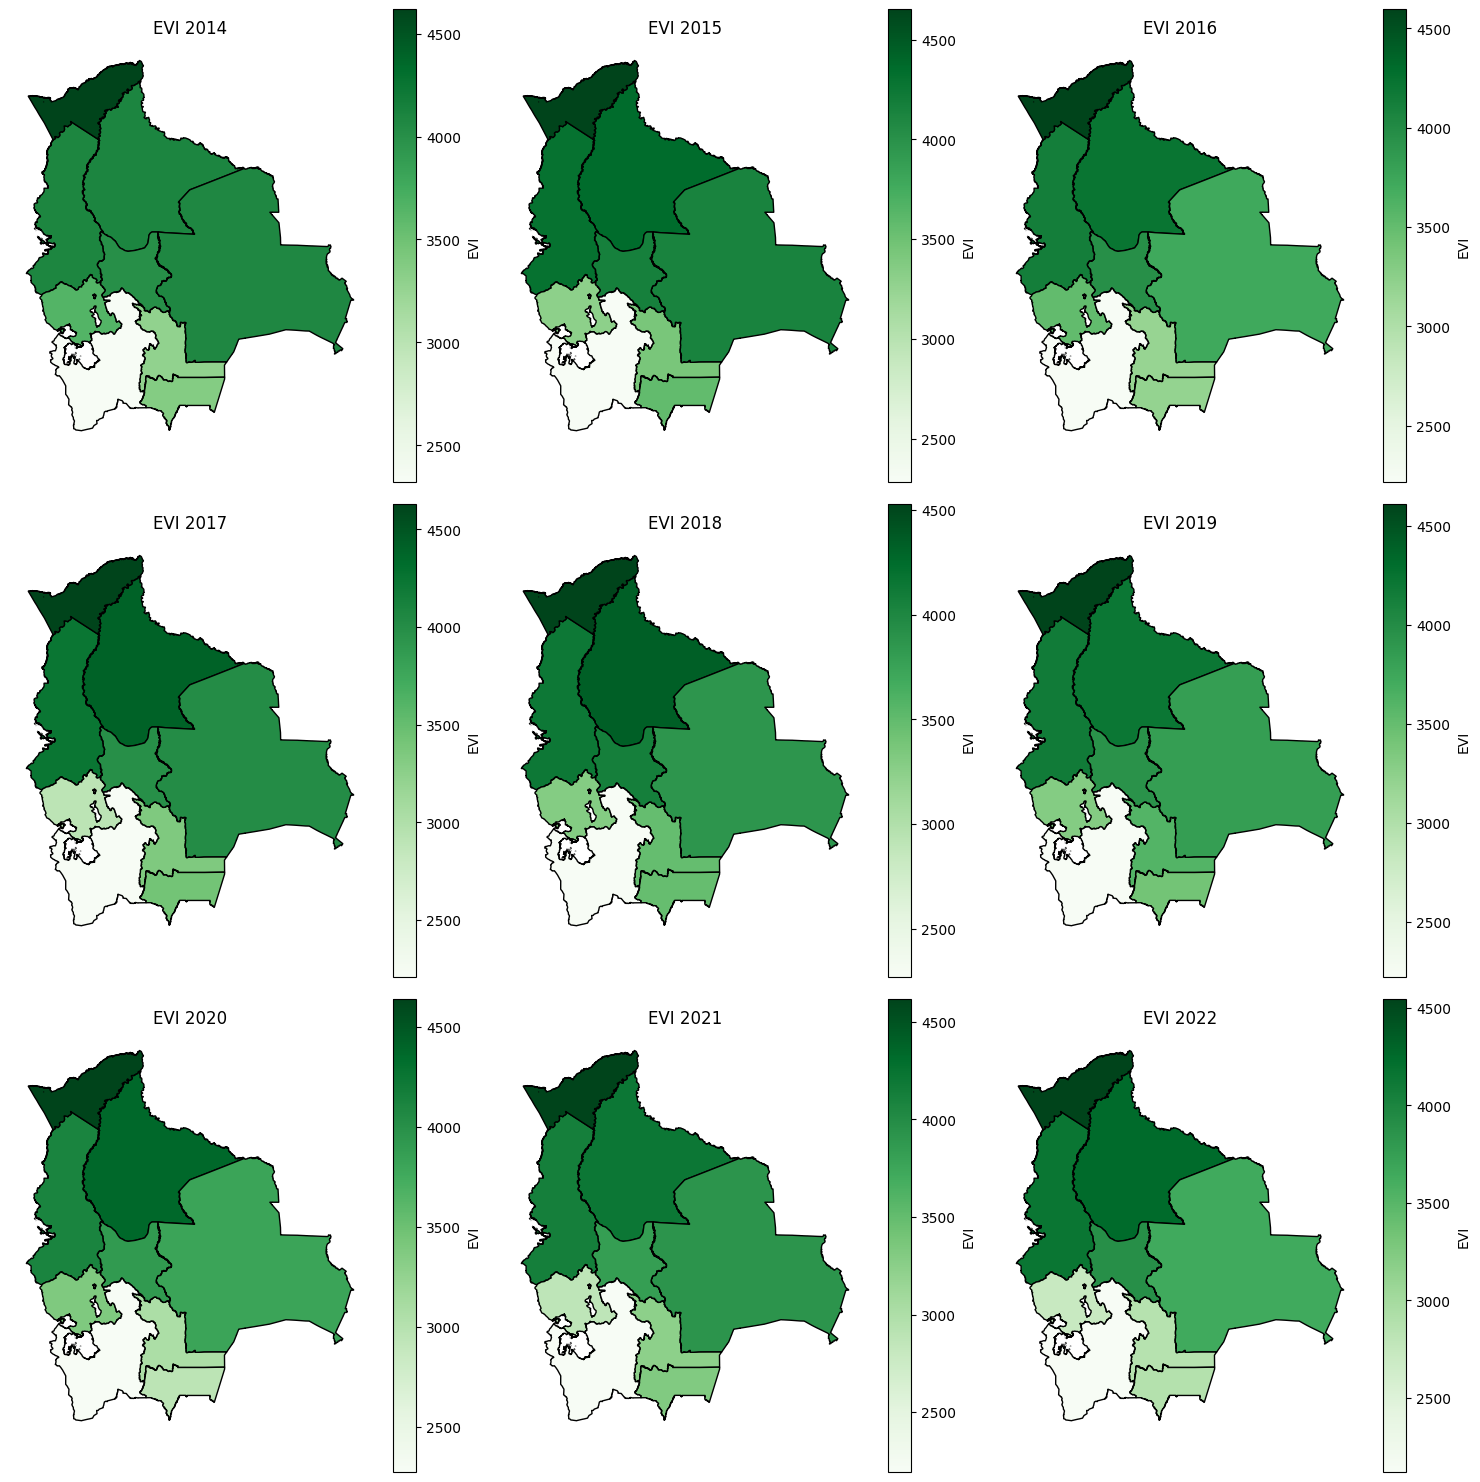

In [97]:
region = gpd.read_file(region_path)

zonal_stats_df = pd.read_csv("../data/zonal_stats/evi_zonal_stats_2014_2022.csv")
gdf = gpd.GeoDataFrame(
    zonal_stats_df,
    geometry=region.geometry,
)


def plot_evi_by_year(gdf: gpd.GeoDataFrame, start_year: int, end_year: int):
    """Plot EVI values by year."""
    years = list(range(start_year, end_year + 1))
    # Make the subplots to be several rows and columns
    fig, axes = plt.subplots(
        nrows=len(years) // 3 + (len(years) % 3 > 0),
        ncols=3,
        figsize=(15, 5 * (len(years) // 3 + (len(years) % 3 > 0))),
    )
    axes = axes.flatten() if len(years) > 1 else [axes]
    for i, year in enumerate(years):
        ax = axes[i]
        gdf.plot(
            column=f"EVI_{year}",
            ax=ax,
            legend=True,
            cmap="Greens",
            edgecolor="black",
            legend_kwds={"label": "EVI"},
        )
        ax.set_title(f"EVI {year}")
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()


plot_evi_by_year(gdf, start_year=2014, end_year=2022)

<Axes: xlabel='year', ylabel='EVI'>

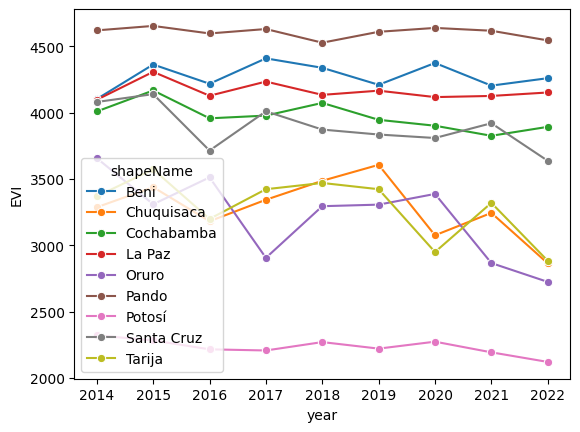

In [96]:
start_year = 2014
end_year = 2022


def pivot_evi_data(
    gdf: gpd.GeoDataFrame, start_year: int, end_year: int
) -> gpd.GeoDataFrame:
    """Pivot the EVI data to long format."""
    evi_columns = [f"EVI_{year}" for year in range(start_year, end_year + 1)]
    gdf_long = gdf.melt(id_vars=["shapeName", "geometry"], value_vars=evi_columns)
    gdf_long.columns = ["shapeName", "geometry", "year", "EVI"]
    gdf_long["year"] = gdf_long["year"].str.replace("EVI_", "").astype(int)
    return gdf_long


gdf_long = pivot_evi_data(gdf, start_year, end_year)


def get_variation(values):
    base = values.iloc[0]  # first element in window iteration
    current = values.iloc[-1]  # last element in window iteration
    return (current - base) / base if base else 0  # avoid ZeroDivisionError


gdf_long = gdf_long.assign(
    change=gdf_long.groupby("shapeName")["EVI"]
    .expanding(min_periods=2)
    .apply(get_variation)
    .droplevel(0)
)

sns.lineplot(
    data=gdf_long,
    x="year",
    y="EVI",
    hue="shapeName",
    marker="o",
    legend="full",
)

## Create EVI summary plot based on each cropland value

In [98]:
region = gpd.read_file(region_path)

zonal_stats_df = pd.read_csv(
    "../data/zonal_stats/evi_zonal_stats_2014_2022_per_crop_value.csv"
)
gdf = gpd.GeoDataFrame(
    zonal_stats_df,
    geometry=region.geometry,
)


# Pivot the EVI data to long format
def pivot_evi_data_per_crop_value(
    gdf: gpd.GeoDataFrame, start_year: int, end_year: int, cropland_values: list[int]
) -> gpd.GeoDataFrame:
    """Pivot the EVI data to long format for each crop value."""
    evi_columns = [
        f"EVI_{year}_crop_{crop_value}"
        for year in range(start_year, end_year + 1)
        for crop_value in cropland_values
    ]
    gdf_long = gdf.melt(id_vars=["shapeName", "geometry"], value_vars=evi_columns)
    gdf_long.columns = ["shapeName", "geometry", "year_crop_value", "EVI"]
    gdf_long[["year", "crop_value"]] = gdf_long["year_crop_value"].str.extract(
        r"EVI_(\d+)_crop_(\d+)"
    )
    gdf_long["year"] = gdf_long["year"].astype(int)
    gdf_long["crop_value"] = gdf_long["crop_value"].astype(int)
    gdf_long["crop_name"] = gdf_long["crop_value"].map(
        {
            10: "Rainfed Cropland",
            11: "Herbaceous Cover Cropland",
            12: "Tree or Shrub Cover Cropland",
            20: "Irrigated Cropland",
        }
    )
    return gdf_long


gdf_long_per_crop_value = pivot_evi_data_per_crop_value(
    gdf, start_year, end_year, cropland_values
)

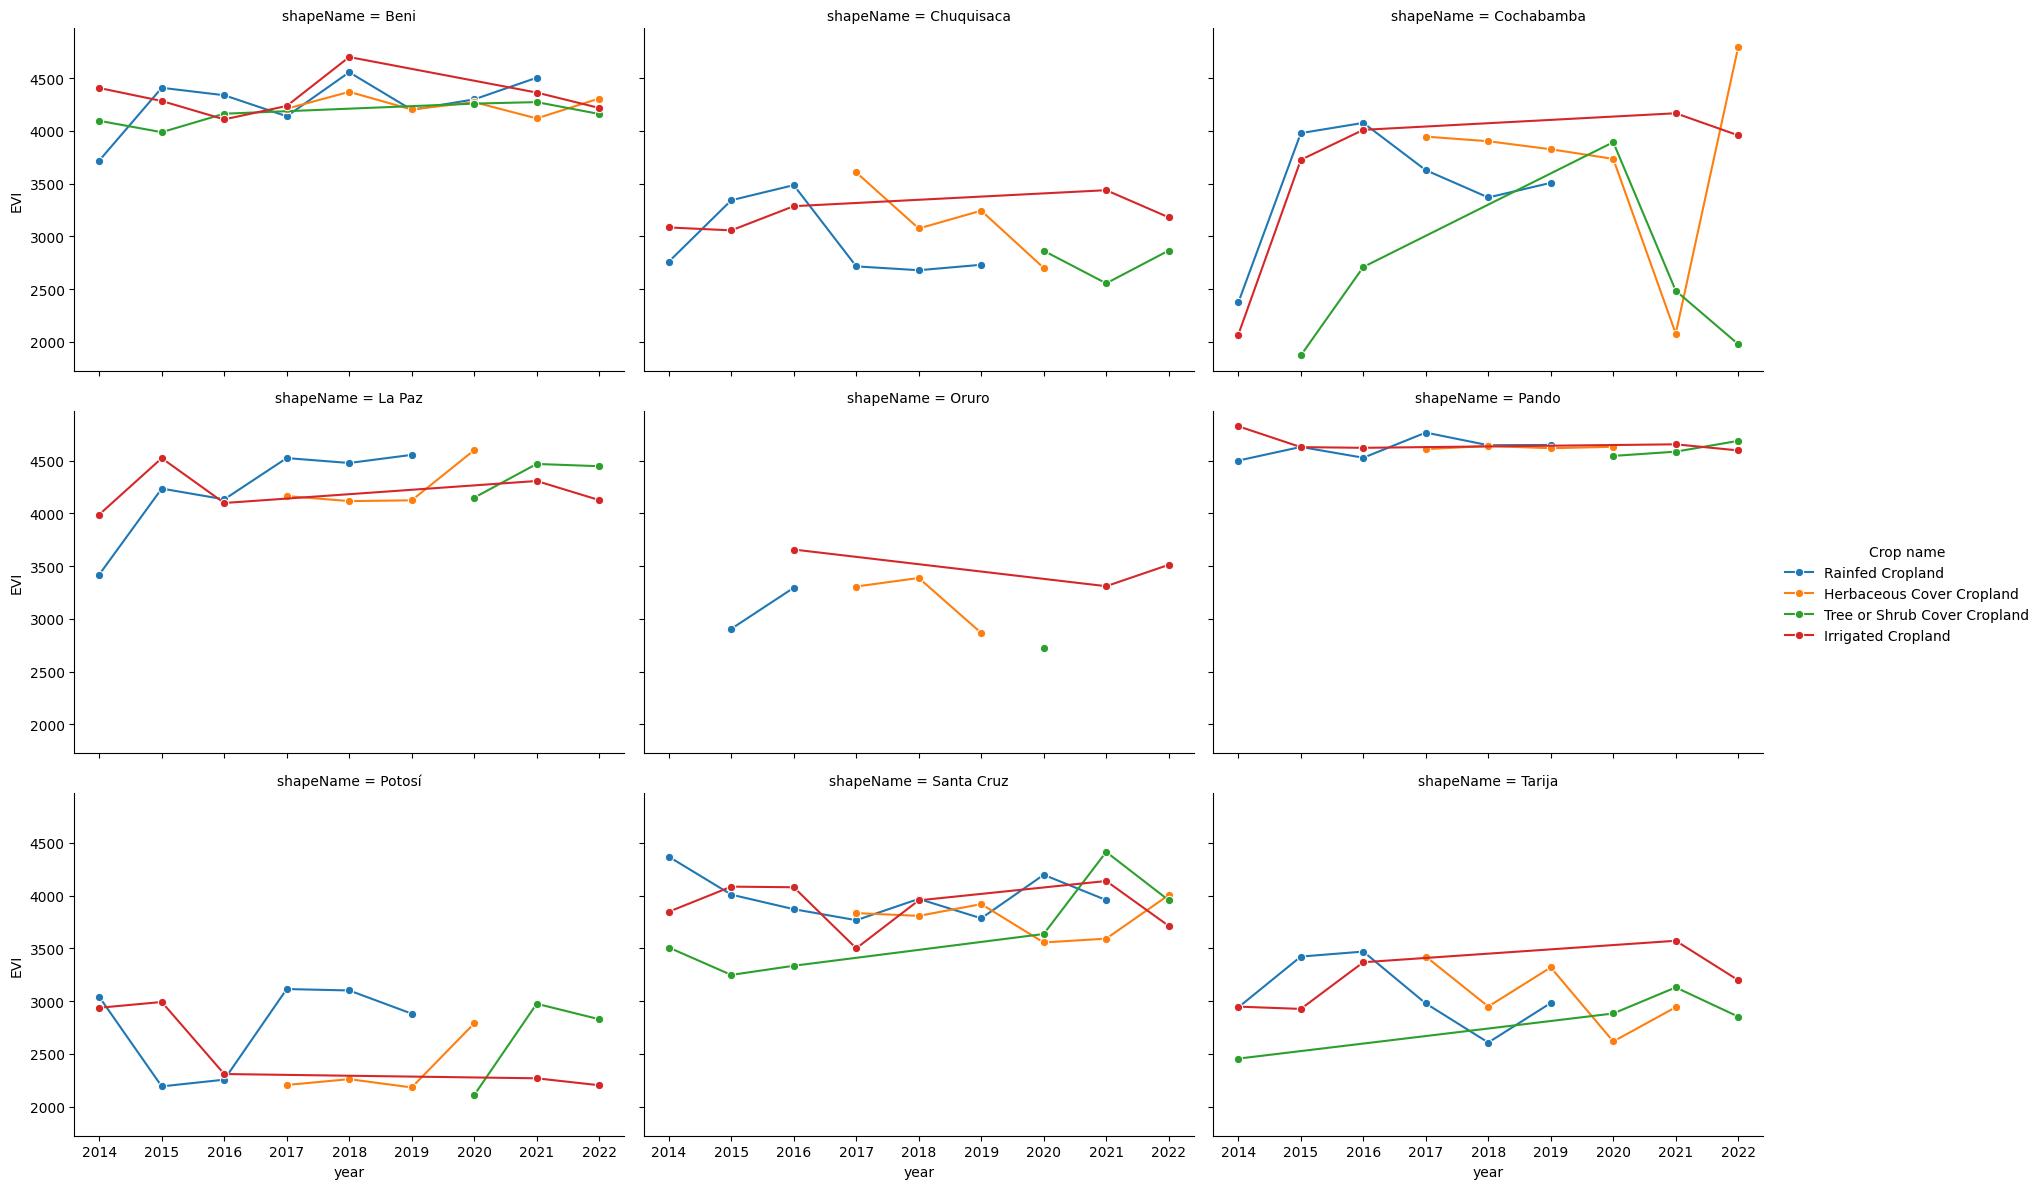

In [89]:
import seaborn as sns


g = sns.FacetGrid(
    gdf_long_per_crop_value,
    col="shapeName",
    hue="crop_name",
    col_wrap=3,
    height=4,
    aspect=1.5,
)

g.map_dataframe(
    sns.lineplot,
    x="year",
    y="EVI",
    marker="o",
    palette="tab10",
)
g.add_legend(title="Crop name")